# Model Performance Visualization Across Visits

This notebook visualizes classifier performance metrics (Accuracy, Precision, Recall, F1, ROC AUC) across different visit counts for CN→MCI and MCI→AD progression prediction.

In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [2]:
def parse_report_file(filepath):
    """Parse a report text file and extract metrics with confidence intervals."""
    with open(filepath, 'r') as f:
        content = f.read()
    
    # Extract dataset base and progression type
    dataset_match = re.search(r'Dataset base: (\S+)', content)
    prog_match = re.search(r'Progression type: (\S+)', content)
    
    if not dataset_match or not prog_match:
        return None
    
    dataset_base = dataset_match.group(1)
    progression_type = prog_match.group(1)
    
    # Extract visit number from dataset name (e.g., "2visit_CN_MCI" -> 2)
    visit_match = re.search(r'(\d+)visit', dataset_base)
    if not visit_match:
        return None
    visits = int(visit_match.group(1))
    
    # Extract base ROC AUC
    base_auc_match = re.search(r'Base ROC AUC: ([\d.]+)', content)
    base_auc = float(base_auc_match.group(1)) if base_auc_match else None
    
    # Extract bootstrap metrics with CIs
    metrics = {}
    
    # Pattern: - MetricName: value (CI: lower, upper)
    metric_pattern = r'- ([^:]+): ([\d.]+) \(CI: ([\d.]+), ([\d.]+)\)'
    for match in re.finditer(metric_pattern, content):
        metric_name = match.group(1).strip()
        point = float(match.group(2))
        ci_low = float(match.group(3))
        ci_high = float(match.group(4))
        metrics[metric_name] = {'point': point, 'ci_low': ci_low, 'ci_high': ci_high}
    
    return {
        'dataset': dataset_base,
        'progression': progression_type,
        'visits': visits,
        'base_auc': base_auc,
        'metrics': metrics
    }

In [3]:
# Parse all report files
reports_dir = Path('saved_models')
report_files = list(reports_dir.glob('*_report_*.txt'))

data = []
for report_file in report_files:
    parsed = parse_report_file(report_file)
    if parsed:
        data.append(parsed)

print(f"Parsed {len(data)} report files")
for d in sorted(data, key=lambda x: (x['progression'], x['visits'])):
    print(f"  {d['visits']} visits - {d['progression']}: {d['dataset']}")

Parsed 8 report files
  2 visits - AD: 2visit_MCI_AD
  3 visits - AD: 3visit_MCI_AD
  4 visits - AD: 4visit_MCI_AD
  5 visits - AD: 5visit_MCI_AD
  2 visits - MCI: 2visit_CN_MCI
  3 visits - MCI: 3visit_CN_MCI
  4 visits - MCI: 4visit_CN_MCI
  5 visits - MCI: 5visit_CN_MCI


In [4]:
# Separate data by progression type
cn_mci_data = [d for d in data if 'CN_MCI' in d['dataset']]
mci_ad_data = [d for d in data if 'MCI_AD' in d['dataset']]

# Sort by visits
cn_mci_data = sorted(cn_mci_data, key=lambda x: x['visits'])
mci_ad_data = sorted(mci_ad_data, key=lambda x: x['visits'])

print(f"CN→MCI reports: {len(cn_mci_data)}")
print(f"MCI→AD reports: {len(mci_ad_data)}")

CN→MCI reports: 4
MCI→AD reports: 4


In [5]:
def plot_metrics_with_ci(data_list, title_prefix, filename_prefix):
    """Plot all metrics with confidence intervals for a progression type."""
    if not data_list:
        print(f"No data for {title_prefix}")
        return
    
    visits = [d['visits'] for d in data_list]
    
    # Metrics to plot
    metric_names = ['Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1 (macro)', 'ROC AUC']
    
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()
    
    for idx, metric_name in enumerate(metric_names):
        ax = axes[idx]
        
        points = []
        ci_lows = []
        ci_highs = []
        
        for d in data_list:
            if metric_name in d['metrics']:
                m = d['metrics'][metric_name]
                points.append(m['point'])
                ci_lows.append(m['ci_low'])
                ci_highs.append(m['ci_high'])
            else:
                points.append(np.nan)
                ci_lows.append(np.nan)
                ci_highs.append(np.nan)
        
        # Convert to numpy arrays
        points = np.array(points)
        ci_lows = np.array(ci_lows)
        ci_highs = np.array(ci_highs)
        
        # Plot line with markers
        ax.plot(visits, points, marker='o', linewidth=2, markersize=8, label=metric_name)
        
        # Plot confidence interval as shaded region
        ax.fill_between(visits, ci_lows, ci_highs, alpha=0.3)
        
        # Add error bars
        ax.errorbar(visits, points, 
                    yerr=[points - ci_lows, ci_highs - points],
                    fmt='none', ecolor='gray', alpha=0.5, capsize=4)
        
        ax.set_xlabel('Number of Visits', fontsize=11)
        ax.set_ylabel(metric_name, fontsize=11)
        ax.set_title(f'{metric_name}', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.set_xticks(visits)
        ax.set_ylim([0, 1.05])
    
    # Hide the extra subplot
    axes[-1].axis('off')
    
    fig.suptitle(f'{title_prefix} - Performance Metrics Across Visits\n(with 95% Bootstrap Confidence Intervals)', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    # Save figure
    plt.savefig(f'{filename_prefix}_performance.png', dpi=300, bbox_inches='tight')
    plt.show()

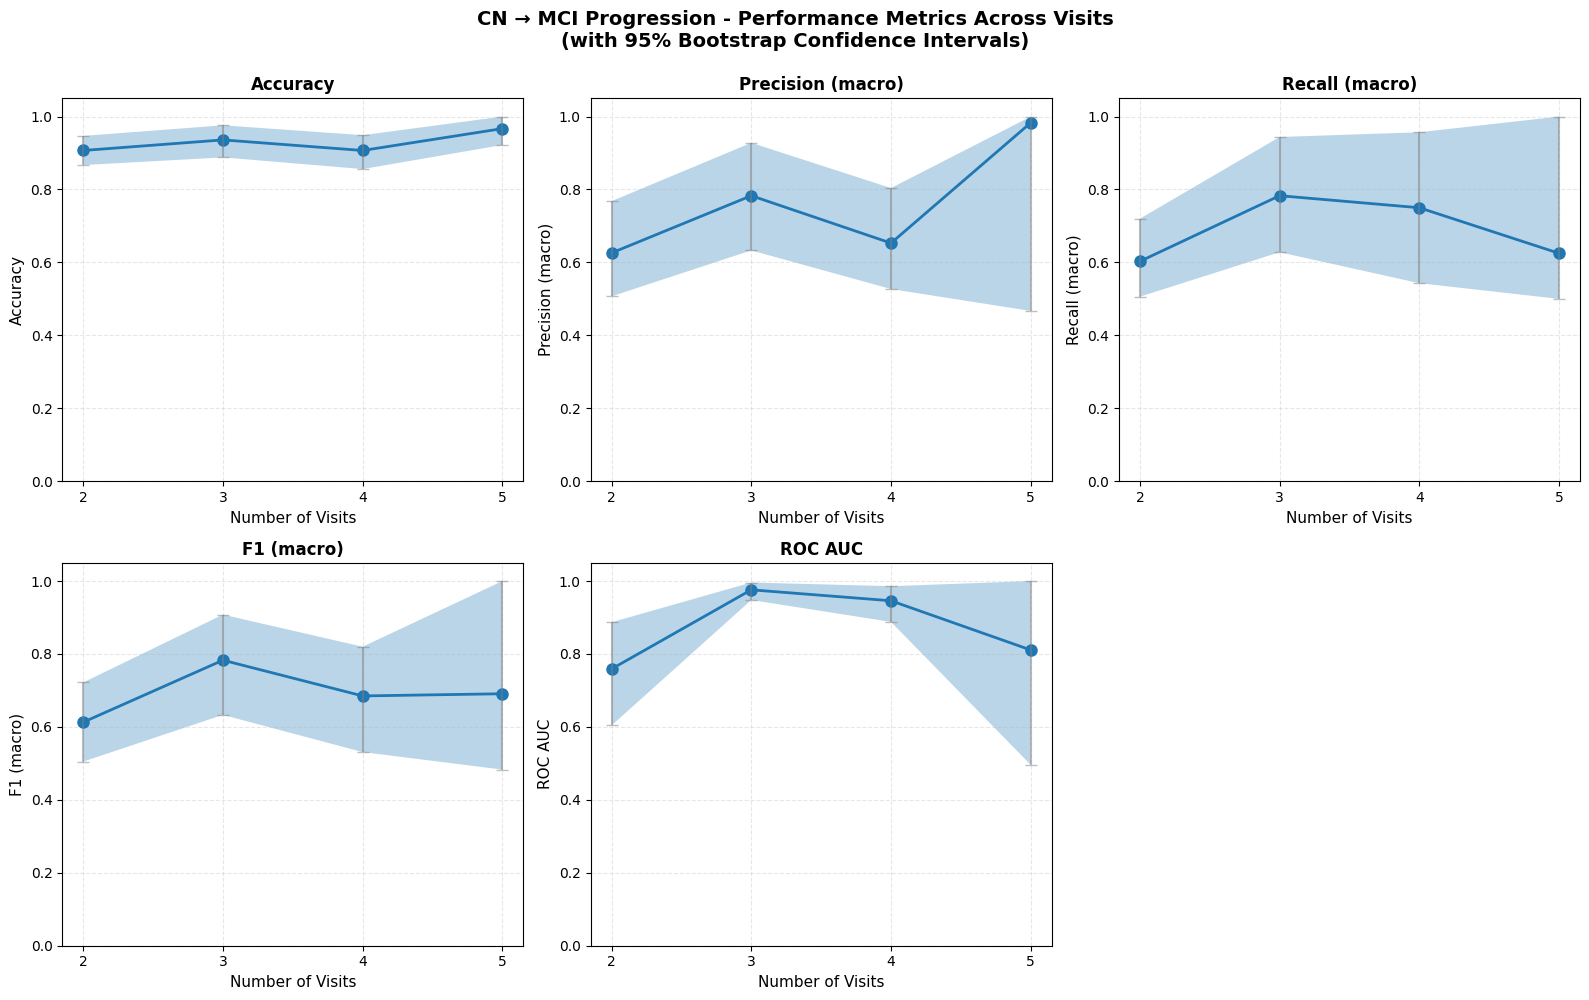

In [6]:
# Plot CN→MCI progression
plot_metrics_with_ci(cn_mci_data, 'CN → MCI Progression', 'cn_mci')

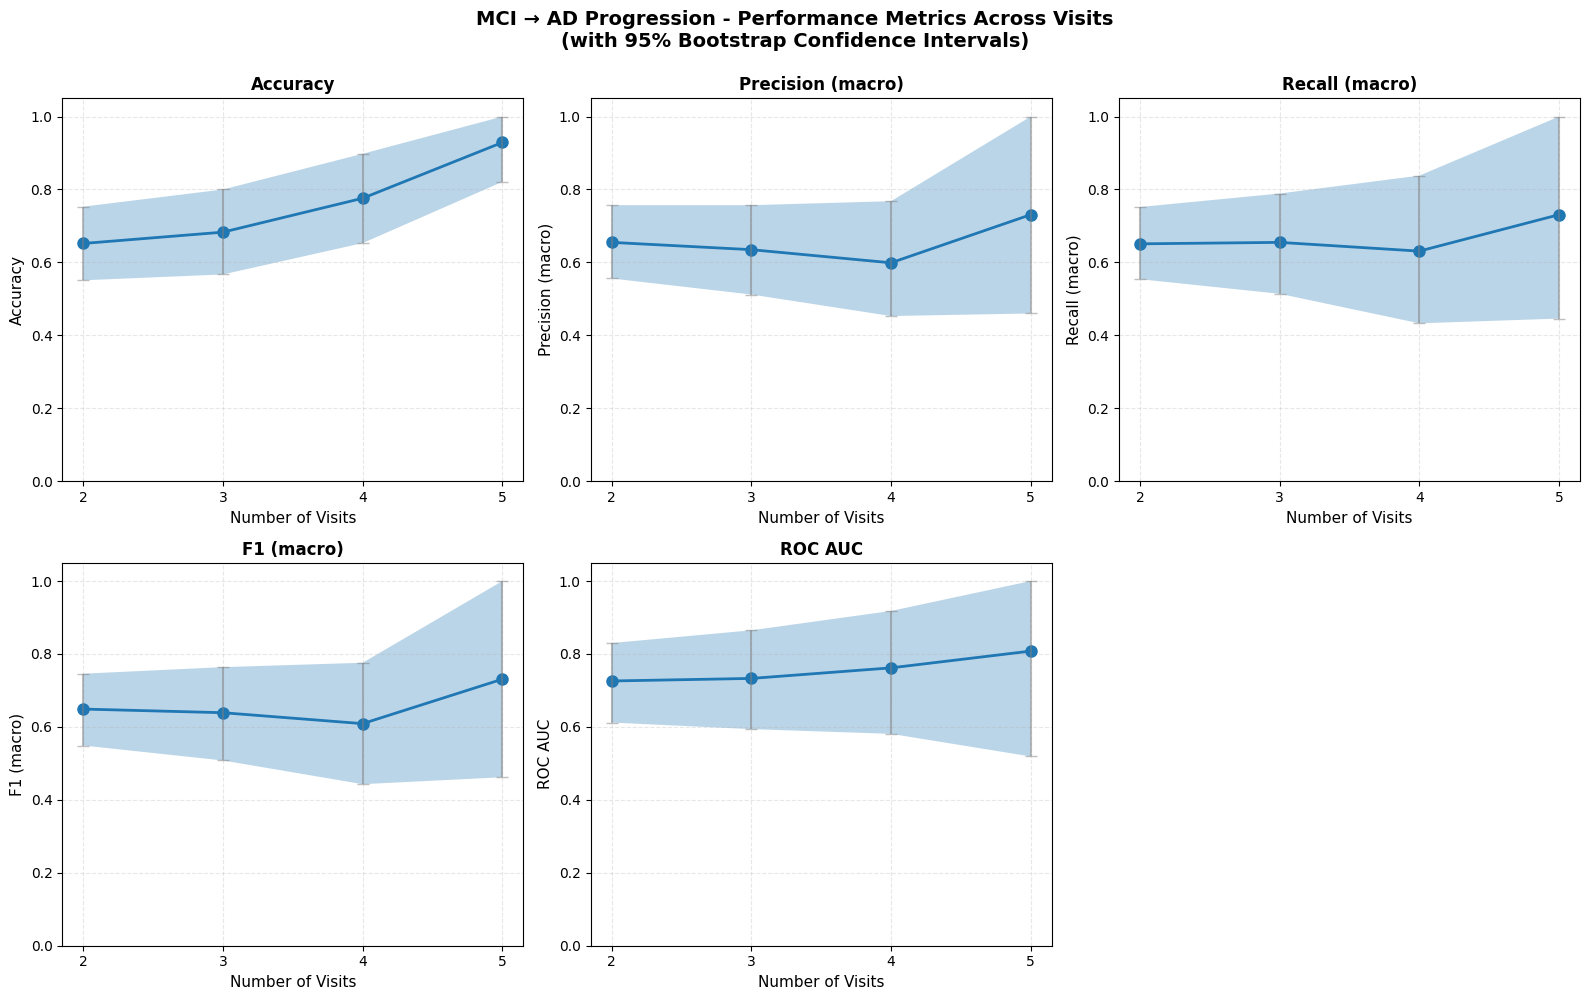

In [7]:
# Plot MCI→AD progression
plot_metrics_with_ci(mci_ad_data, 'MCI → AD Progression', 'mci_ad')

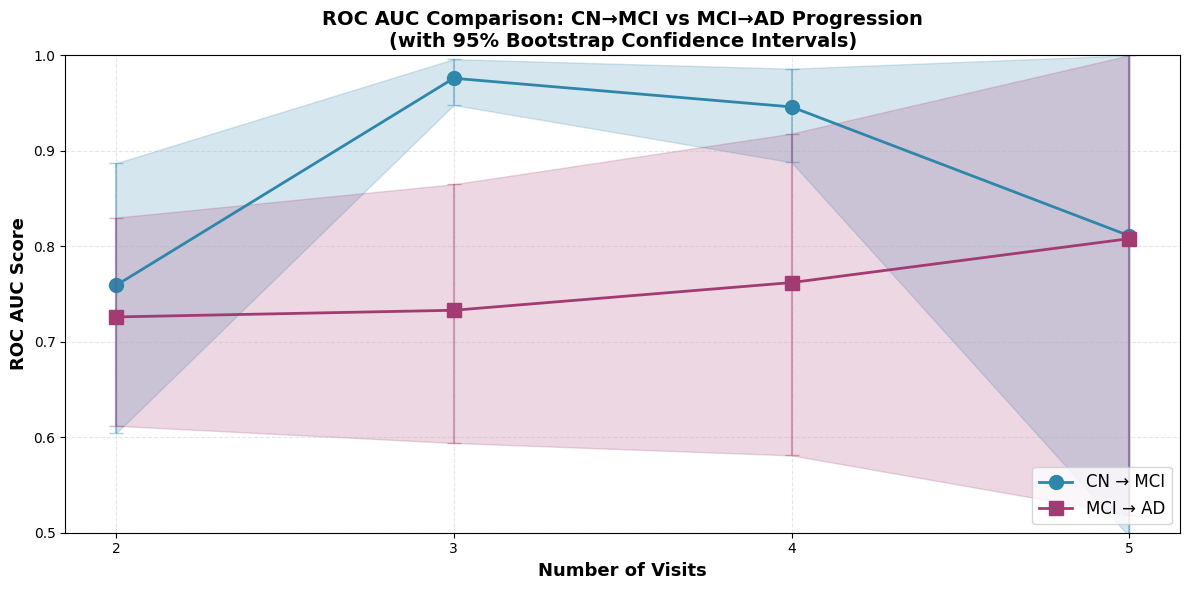

In [8]:
# Create a combined comparison plot
def plot_combined_comparison(cn_mci_data, mci_ad_data):
    """Create a combined plot comparing ROC AUC for both progression types."""
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    # CN→MCI
    if cn_mci_data:
        visits_cn = [d['visits'] for d in cn_mci_data]
        points_cn = [d['metrics']['ROC AUC']['point'] if 'ROC AUC' in d['metrics'] else np.nan for d in cn_mci_data]
        ci_lows_cn = [d['metrics']['ROC AUC']['ci_low'] if 'ROC AUC' in d['metrics'] else np.nan for d in cn_mci_data]
        ci_highs_cn = [d['metrics']['ROC AUC']['ci_high'] if 'ROC AUC' in d['metrics'] else np.nan for d in cn_mci_data]
        
        ax.plot(visits_cn, points_cn, marker='o', linewidth=2, markersize=10, label='CN → MCI', color='#2E86AB')
        ax.fill_between(visits_cn, ci_lows_cn, ci_highs_cn, alpha=0.2, color='#2E86AB')
        ax.errorbar(visits_cn, points_cn, 
                    yerr=[np.array(points_cn) - np.array(ci_lows_cn), 
                          np.array(ci_highs_cn) - np.array(points_cn)],
                    fmt='none', ecolor='#2E86AB', alpha=0.4, capsize=5)
    
    # MCI→AD
    if mci_ad_data:
        visits_ad = [d['visits'] for d in mci_ad_data]
        points_ad = [d['metrics']['ROC AUC']['point'] if 'ROC AUC' in d['metrics'] else np.nan for d in mci_ad_data]
        ci_lows_ad = [d['metrics']['ROC AUC']['ci_low'] if 'ROC AUC' in d['metrics'] else np.nan for d in mci_ad_data]
        ci_highs_ad = [d['metrics']['ROC AUC']['ci_high'] if 'ROC AUC' in d['metrics'] else np.nan for d in mci_ad_data]
        
        ax.plot(visits_ad, points_ad, marker='s', linewidth=2, markersize=10, label='MCI → AD', color='#A23B72')
        ax.fill_between(visits_ad, ci_lows_ad, ci_highs_ad, alpha=0.2, color='#A23B72')
        ax.errorbar(visits_ad, points_ad, 
                    yerr=[np.array(points_ad) - np.array(ci_lows_ad), 
                          np.array(ci_highs_ad) - np.array(points_ad)],
                    fmt='none', ecolor='#A23B72', alpha=0.4, capsize=5)
    
    ax.set_xlabel('Number of Visits', fontsize=13, fontweight='bold')
    ax.set_ylabel('ROC AUC Score', fontsize=13, fontweight='bold')
    ax.set_title('ROC AUC Comparison: CN→MCI vs MCI→AD Progression\n(with 95% Bootstrap Confidence Intervals)', 
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=12, loc='lower right')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_ylim([0.5, 1.0])
    
    # Set x-axis to show only integer visit counts
    all_visits = sorted(set(visits_cn if cn_mci_data else []) | set(visits_ad if mci_ad_data else []))
    ax.set_xticks(all_visits)
    
    plt.tight_layout()
    plt.savefig('combined_auc_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_combined_comparison(cn_mci_data, mci_ad_data)

In [9]:
# Create summary table
def create_summary_table(data_list, progression_label):
    """Create a pandas DataFrame summarizing metrics."""
    rows = []
    for d in sorted(data_list, key=lambda x: x['visits']):
        row = {'Visits': d['visits'], 'Progression': progression_label}
        for metric_name in ['Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1 (macro)', 'ROC AUC']:
            if metric_name in d['metrics']:
                m = d['metrics'][metric_name]
                row[f"{metric_name}"] = f"{m['point']:.3f} ({m['ci_low']:.3f}, {m['ci_high']:.3f})"
            else:
                row[f"{metric_name}"] = 'N/A'
        rows.append(row)
    return pd.DataFrame(rows)

# Create tables
cn_mci_table = create_summary_table(cn_mci_data, 'CN→MCI')
mci_ad_table = create_summary_table(mci_ad_data, 'MCI→AD')

print("\n=== CN→MCI Performance Summary ===")
print(cn_mci_table.to_string(index=False))

print("\n=== MCI→AD Performance Summary ===")
print(mci_ad_table.to_string(index=False))

# Save tables to CSV
cn_mci_table.to_csv('cn_mci_summary.csv', index=False)
mci_ad_table.to_csv('mci_ad_summary.csv', index=False)
print("\nSummary tables saved to CSV files.")


=== CN→MCI Performance Summary ===
 Visits Progression             Accuracy    Precision (macro)       Recall (macro)           F1 (macro)              ROC AUC
      2      CN→MCI 0.907 (0.867, 0.947) 0.626 (0.507, 0.768) 0.603 (0.506, 0.720) 0.613 (0.505, 0.722) 0.759 (0.604, 0.887)
      3      CN→MCI 0.936 (0.888, 0.976) 0.783 (0.633, 0.928) 0.783 (0.628, 0.944) 0.783 (0.633, 0.908) 0.976 (0.948, 0.996)
      4      CN→MCI 0.907 (0.856, 0.949) 0.653 (0.527, 0.804) 0.750 (0.543, 0.957) 0.685 (0.531, 0.820) 0.946 (0.888, 0.986)
      5      CN→MCI 0.967 (0.922, 1.000) 0.983 (0.467, 1.000) 0.625 (0.500, 1.000) 0.691 (0.483, 1.000) 0.811 (0.496, 1.000)

=== MCI→AD Performance Summary ===
 Visits Progression             Accuracy    Precision (macro)       Recall (macro)           F1 (macro)              ROC AUC
      2      MCI→AD 0.652 (0.551, 0.753) 0.655 (0.556, 0.757) 0.651 (0.554, 0.752) 0.649 (0.549, 0.746) 0.726 (0.612, 0.830)
      3      MCI→AD 0.683 (0.567, 0.800) 0.635 (0.512

Experiment #2

In [4]:
# Parse all report files
reports_dir = Path('saved_models_2')
report_files = list(reports_dir.glob('*_report_*.txt'))

data = []
for report_file in report_files:
    parsed = parse_report_file(report_file)
    if parsed:
        data.append(parsed)

print(f"Parsed {len(data)} report files")
for d in sorted(data, key=lambda x: (x['progression'], x['visits'])):
    print(f"  {d['visits']} visits - {d['progression']}: {d['dataset']}")

# Separate data by progression type
cn_mci_data = [d for d in data if 'CN_MCI' in d['dataset']]
mci_ad_data = [d for d in data if 'MCI_AD' in d['dataset']]

# Sort by visits
cn_mci_data = sorted(cn_mci_data, key=lambda x: x['visits'])
mci_ad_data = sorted(mci_ad_data, key=lambda x: x['visits'])

print(f"CN→MCI reports: {len(cn_mci_data)}")
print(f"MCI→AD reports: {len(mci_ad_data)}")

Parsed 8 report files
  2 visits - AD: 2visit_MCI_AD
  3 visits - AD: 3visit_MCI_AD
  4 visits - AD: 4visit_MCI_AD
  5 visits - AD: 5visit_MCI_AD
  2 visits - MCI: 2visit_CN_MCI
  3 visits - MCI: 3visit_CN_MCI
  4 visits - MCI: 4visit_CN_MCI
  5 visits - MCI: 5visit_CN_MCI
CN→MCI reports: 4
MCI→AD reports: 4


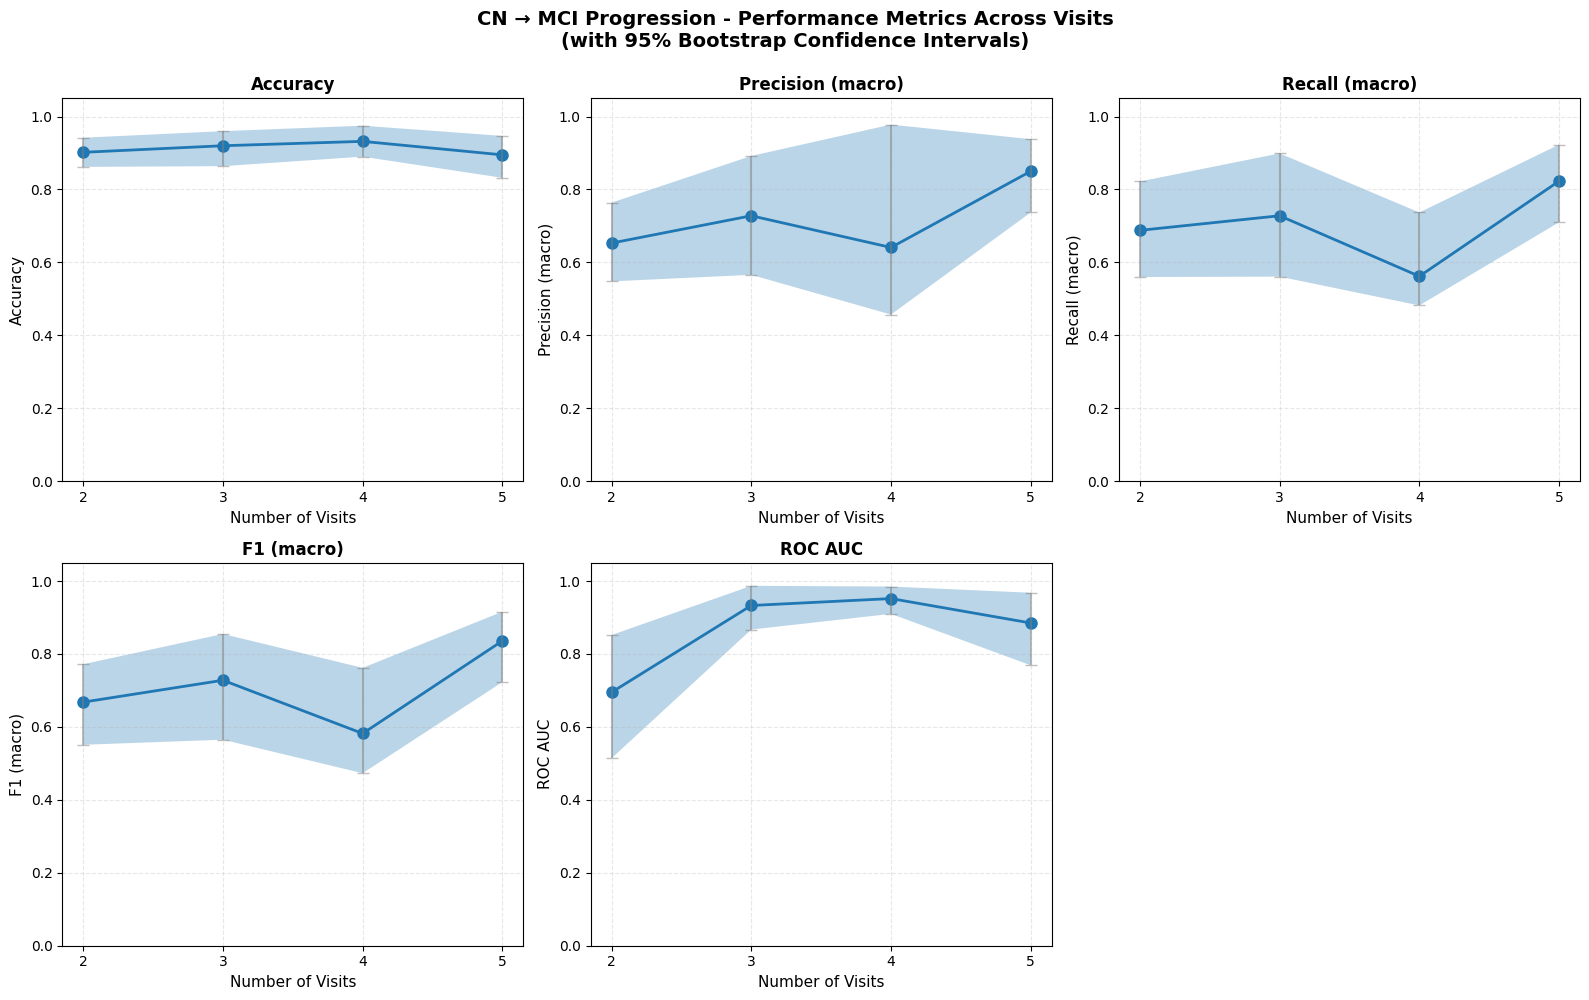

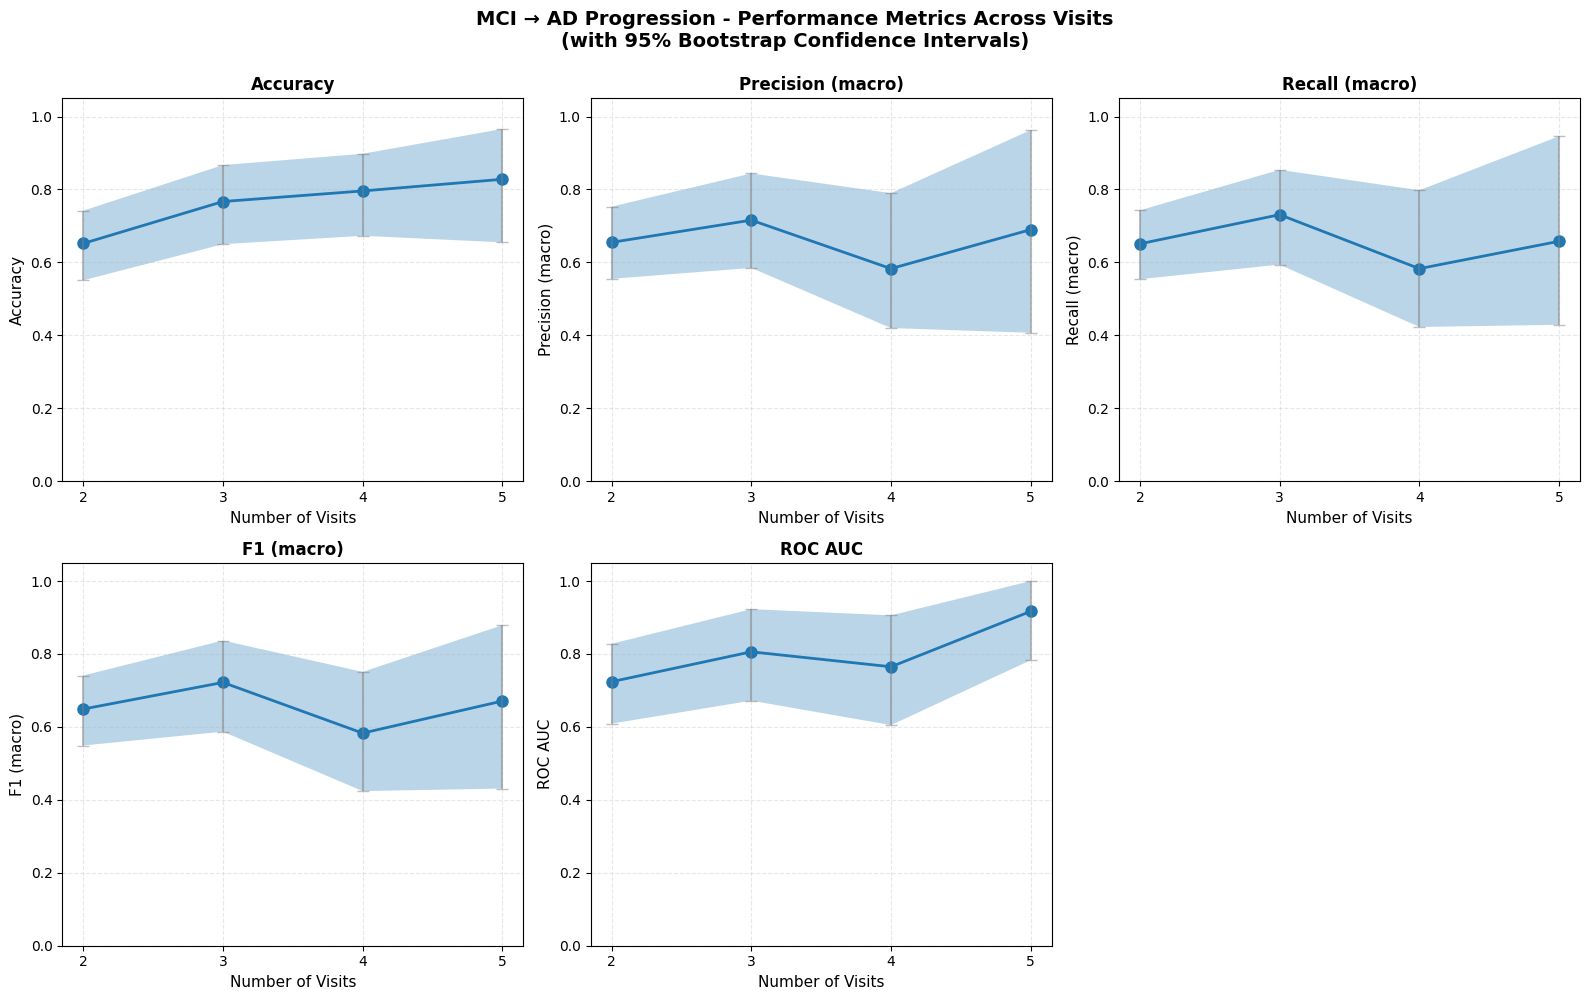

In [6]:
plot_metrics_with_ci(cn_mci_data, 'CN → MCI Progression', 'cn_mci')
# Plot MCI→AD progression
plot_metrics_with_ci(mci_ad_data, 'MCI → AD Progression', 'mci_ad')